# Adam (Adaptive Moment Estimation) Logic

When the gradient of the loss surface is much steeper in one direction than another, it is difficult to choose a learning rate that makes good progress in both directions and is stable. A straightforward approach is to normalize the gradients so that we move a fixed distance (governed by the learning rate) in each direction. To do this, we first measure the gradient $m_{t+1}$ and the pointwise squared gradient $v_{t+1}$:

$$m_{t+1} \leftarrow \frac{\partial L(\phi_t)}{\partial \phi}$$

$$v_{t+1} \leftarrow \left( \frac{\partial L(\phi_t)}{\partial \phi} \right)^2$$

Then we apply the update rule:

$$\phi_{t+1} \leftarrow \phi_t - \alpha \cdot \frac{m_{t+1}}{\sqrt{v_{t+1}} + \epsilon}$$

where:
- the square root and division are both pointwise
- $\alpha$: learning rate
- $\epsilon$: small constant that prevents division by zero when the gradient magnitude is zero

The term $v_{t+1}$ is the squared gradient and the positive root of this is used to normalize the gradient itself, so all that remains is the sign in each coordinate direction. The result is that the algorithm moves a fixed distance $\alpha$ along each coordinate, where the direction is determined by whichever way is downhill. This simple algorithm makes good progress in both directions but will not converge unless it happens to land exactly at the minimum. Instead, it will bounce back and forth around the minimum.

Adaptive moment estimation, or Adam, takes this idea and adds momentum to both the estimate of the gradient and the squared gradient:

$$m_{t+1} \leftarrow \beta \cdot m_t + (1 - \beta) \frac{\partial L(\phi_t)}{\partial \phi}$$

$$v_{t+1} \leftarrow \gamma \cdot v_t + (1 - \gamma) \left( \frac{\partial L(\phi_t)}{\partial \phi} \right)^2$$

where:
- $\gamma$ & $\beta$: the momentum coefficients for the two statistics

Using momentum is equivalent to taking a weighted average over the history of each of these statistics. At the start of the procedure, all the previous measurements are effectively zero, resulting in unrealistically small estimates. Consequently, we modify these statistics using the rule:

$$\hat{m}_{t+1} \leftarrow \frac{m_{t+1}}{1 - \beta^{t+1}}$$

$$\hat{v}_{t+1} \leftarrow \frac{v_{t+1}}{1 - \gamma^{t+1}}$$

Since $\beta$ and $\gamma$ are in the range $[0,1)$, the terms with exponents $t+1$ become smaller with each time step, the denominators become closer to one, and this modification has a diminishing effect.

Finally, we update the parameters as before, but with the modified terms:

$$\phi_{t+1} \leftarrow \phi_t - \alpha \cdot \frac{\hat{m}_{t+1}}{\sqrt{\hat{v}_{t+1}} + \epsilon}$$

The result is an algorithm that can converge to the overall minimum and makes good progress in every direction in the parameter space. Note that Adam is usually used in a stochastic setting where the gradients and their squares are computed from mini-batches:

$$m_{t+1} \leftarrow \beta \cdot m_t + (1 - \beta) \sum_{i \in B_t} \frac{\partial \ell(\phi_t)}{\partial \phi}$$

$$v_{t+1} \leftarrow \gamma \cdot v_t + (1 - \gamma) \sum_{i \in B_t} \left( \frac{\partial \ell(\phi_t)}{\partial \phi} \right)^2$$

The gradient magnitudes of neural network parameters can depend on their depth in the network. Adam helps compensate for this tendency and balances out changes across the different layers. In practice, Adam also has the advantage of being less sensitive to the initial learning rate.

In [63]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [64]:
def SimulateGradient(phiValue:np.ndarray)->int|float:
  """
    Simulate the gradient of a loss function with respect to parameter phi.
    This is a stand-in for a real gradient computation.
  """
  return 2*phi - 4 # Example gradient of a simple quadratic loss function

In [65]:
def AdamUpdate(phi:np.ndarray,gradient:np.ndarray,move:np.ndarray,moveSquared:np.ndarray,timeStep:int,alpha:float=0.01,beta_1:float=0.9,beta_2:float=0.999,epsilon:float=1e-8)->np.ndarray:
  """
    Perform an Adam update on parameters.

    :param phi: Current parameter values
    :param gradient: Gradient of the loss with respect to phi
    :param move: Moving average of the gradients
    :param moveSquared: Moving average of the squared gradients
    :param timeStep: Time step (iteration number)
    :param alpha: Learning rate
    :param beta_1: Momentum term for gradients
    :param beta_2: Momentum term for squared gradients
    :param epsilon: Small constant to avoid division by zero
    :return: Updated parameter value, updated move, updated moveSquared
  """
  move = beta_1*move+(1-beta_1)*gradient
  moveSquared = beta_2*moveSquared+(1-beta_2)*(gradient**2)
  moveHat = move/(1-beta_1**(timeStep+1))
  moveSquaredHat = moveSquared/(1-beta_2**(timeStep+1))
  phi -= alpha*(moveHat/(np.sqrt(moveSquaredHat)+epsilon))
  return phi,move,moveSquared

In [66]:
phiValue = np.array([2.0]) # Starting parameter value
move = np.array([0.0]) # Initial moving average of gradients
moveSquared = np.array([0.0]) # Initial moving average of squared gradients
timeSteps = 100 # Number of iterations to simulate

In [67]:
for step in range(timeSteps):
  gradient = SimulateGradient(phiValue)
  phi,move,moveSquared = AdamUpdate(phiValue,gradient,move,moveSquared,step)
  if step % 20 == 0:
    print(f"Iteration: {step} --> Phi Value: {phi}")

Iteration: 0 --> Phi Value: [2.]
Iteration: 20 --> Phi Value: [2.]
Iteration: 40 --> Phi Value: [2.]
Iteration: 60 --> Phi Value: [2.]
Iteration: 80 --> Phi Value: [2.]


- example:

In [68]:
sample,groundTruth = make_moons(n_samples=1000,noise=0.2,random_state=42)
print(f"Sample shape: {sample.shape}")
print(f"Ground Truth shape: {groundTruth.shape}")

Sample shape: (1000, 2)
Ground Truth shape: (1000,)


In [69]:
groundTruth = groundTruth.reshape(-1,1) # Reshape groundTruth to make it two-dimensional
print(f"Ground Truth shape: {groundTruth.shape}")

Ground Truth shape: (1000, 1)


In [70]:
xTrain,xTest,yTrain,yTest = train_test_split(sample,groundTruth,test_size=0.3,random_state=42)

In [71]:
def Sigmoid(value:int|float)->int|float:
  return 1/(1+np.exp(-value))

In [72]:
def SigmoidDerivative(value:int|float)->int|float:
  return value*(1-value)

In [73]:
np.random.seed(42)

In [74]:
# Initialize parameters
inputSize = xTrain.shape[1]
hiddenSize = 10
outputSize = 1
w1 = np.random.randn(inputSize,hiddenSize)
b1 = np.zeros((1,hiddenSize))
w2 = np.random.randn(hiddenSize,outputSize)
b2 = np.zeros((1,outputSize))
print(f"Weight 1 shape: {w1.shape}")
print(f"Intercept 1 shape: {b1.shape}")
print(f"Weight 2 shape: {w2.shape}")
print(f"Intercept 2 shape: {b2.shape}")

Weight 1 shape: (2, 10)
Intercept 1 shape: (1, 10)
Weight 2 shape: (10, 1)
Intercept 2 shape: (1, 1)


In [75]:
# Adam parameters
mw_1,vw_1 = np.zeros_like(w1),np.zeros_like(w1)
mb_1,vb_1 = np.zeros_like(b1),np.zeros_like(b1)
mw_2,vw_2 = np.zeros_like(w2),np.zeros_like(w2)
mb_2,vb_2 = np.zeros_like(b2),np.zeros_like(b2)

In [76]:
learningRate = 0.01
beta_1,beta_2 = 0.9,0.999
epsilon = 1e-8

In [77]:
def AdamUpdate(parameter:np.ndarray,gradient:np.ndarray,move:np.ndarray,moveSquared:np.ndarray,timeStep:int)->np.ndarray:
  move = beta_1*move+(1-beta_1)-gradient
  moveSquared = beta_2*moveSquared+(1-beta_2)*(gradient**2)
  moveHat = move/(1-beta_1**(timeStep+1))
  moveSquaredHat = moveSquared/(1-beta_2**(timeStep+1))
  parameter -= learningRate*moveHat/(np.sqrt(moveSquaredHat)+epsilon)
  return parameter,move,moveSquared

In [78]:
# Training loop
epochs = 1000
for epoch in range(epochs):
  # Forward pass
  z1 = np.dot(xTrain,w1)+b1
  a1 = np.tanh(z1)
  z2 = np.dot(a1,w2)+b2
  a2 = Sigmoid(z2)
  loss = np.mean(-(yTrain*np.log(a2)+(1-yTrain)*np.log(1-a2)))
  # Backward pass
  dz_2 = a2-yTrain
  dw_2 = np.dot(a1.T,dz_2)
  db_2 = np.sum(dz_2,axis=0,keepdims=True)
  dz_1 = np.dot(dz_2,w2.T)*(1-np.power(a1,2))
  dw_1 = np.dot(xTrain.T,dz_1)
  db_1 = np.sum(dz_1,axis=0)
  # Adam update
  w1,mw_1,vw_1 = AdamUpdate(w1,dw_1,mw_1,vw_1,epoch)
  b1,mb_1,vb_1 = AdamUpdate(b1,db_1,mb_1,vb_1,epoch)
  w2,mw_2,vw_2 = AdamUpdate(w2,dw_2,mw_2,vw_2,epoch)
  b2,mb_2,vb_2 = AdamUpdate(b2,db_2,mb_2,vb_2,epoch)
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} --> Loss: {loss}")

Epoch: 0 --> Loss: 1.6788824394534394
Epoch: 100 --> Loss: nan
Epoch: 200 --> Loss: nan


<ipython-input-78-62070059248c>:9: RuntimeWarning: divide by zero encountered in log
  loss = np.mean(-(yTrain*np.log(a2)+(1-yTrain)*np.log(1-a2)))
<ipython-input-78-62070059248c>:9: RuntimeWarning: invalid value encountered in multiply
  loss = np.mean(-(yTrain*np.log(a2)+(1-yTrain)*np.log(1-a2)))


Epoch: 300 --> Loss: nan
Epoch: 400 --> Loss: nan
Epoch: 500 --> Loss: nan
Epoch: 600 --> Loss: nan
Epoch: 700 --> Loss: nan
Epoch: 800 --> Loss: nan


<ipython-input-71-c2d964b70a01>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-value))


Epoch: 900 --> Loss: nan


In [79]:
# Evaluate the model
z1 = np.dot(xTest,w1)+b1
a1 = np.tanh(z1)
z2 = np.dot(a1,w2)+b2
a2 = Sigmoid(z2)
predictions = a2 > 0.5
accuracy = np.mean(predictions==yTest)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.14333333333333334


<ipython-input-71-c2d964b70a01>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-value))


- complex example:

In [80]:
def LossFunction(phi_0:int|float,phi_1:int|float)->int|float:
  height = np.exp(-0.5*(phi_1**2)*4.0)
  height = height*np.exp(-0.5*(phi_0-0.7)**2/4.0)
  return 1.0-height

In [81]:
def LossGradient(phi_0:int|float,phi_1:int|float)->np.ndarray:
  deltaPhi = 0.00001
  gradient = np.zeros((2,1))
  gradient[0] = (LossFunction(phi_0+deltaPhi/2.0,phi_1)-LossFunction(phi_0-deltaPhi/2.0,phi_1))/deltaPhi
  gradient[1] = (LossFunction(phi_0,phi_1+deltaPhi/2.0)-LossFunction(phi_0,phi_1-deltaPhi/2.0))/deltaPhi
  return gradient[:,0]

In [82]:
def LossPlot():
  gridValues = np.arange(-1.0,1.0,0.01)
  phi_0_Mesh,phi_1_Mesh = np.meshgrid(gridValues,gridValues)
  lossFunctionBase = np.zeros((gridValues.size,gridValues.size))
  for phiIDX_0,phi_0 in enumerate(gridValues):
    for phiIDX_1,phi_1 in enumerate(gridValues):
      lossFunctionBase[phiIDX_0,phiIDX_1] = LossFunction(phi_1,phi_0)
  return lossFunctionBase,phi_0_Mesh,phi_1_Mesh

In [83]:
# Define fancy colormap
my_colormap_vals_hex =('2a0902', '2b0a03', '2c0b04', '2d0c05', '2e0c06', '2f0d07', '300d08', '310e09', '320f0a', '330f0b', '34100b', '35110c', '36110d', '37120e', '38120f', '39130f', '3a1410', '3b1411', '3c1511', '3d1612', '3e1613', '3f1713', '401714', '411814', '421915', '431915', '451a16', '461b16', '471b17', '481c17', '491d18', '4a1d18', '4b1e19', '4c1f19', '4d1f1a', '4e201b', '50211b', '51211c', '52221c', '53231d', '54231d', '55241e', '56251e', '57261f', '58261f', '592720', '5b2821', '5c2821', '5d2922', '5e2a22', '5f2b23', '602b23', '612c24', '622d25', '632e25', '652e26', '662f26', '673027', '683027', '693128', '6a3229', '6b3329', '6c342a', '6d342a', '6f352b', '70362c', '71372c', '72372d', '73382e', '74392e', '753a2f', '763a2f', '773b30', '783c31', '7a3d31', '7b3e32', '7c3e33', '7d3f33', '7e4034', '7f4134', '804235', '814236', '824336', '834437', '854538', '864638', '874739', '88473a', '89483a', '8a493b', '8b4a3c', '8c4b3c', '8d4c3d', '8e4c3e', '8f4d3f', '904e3f', '924f40', '935041', '945141', '955242', '965343', '975343', '985444', '995545', '9a5646', '9b5746', '9c5847', '9d5948', '9e5a49', '9f5a49', 'a05b4a', 'a15c4b', 'a35d4b', 'a45e4c', 'a55f4d', 'a6604e', 'a7614e', 'a8624f', 'a96350', 'aa6451', 'ab6552', 'ac6552', 'ad6653', 'ae6754', 'af6855', 'b06955', 'b16a56', 'b26b57', 'b36c58', 'b46d59', 'b56e59', 'b66f5a', 'b7705b', 'b8715c', 'b9725d', 'ba735d', 'bb745e', 'bc755f', 'bd7660', 'be7761', 'bf7862', 'c07962', 'c17a63', 'c27b64', 'c27c65', 'c37d66', 'c47e67', 'c57f68', 'c68068', 'c78169', 'c8826a', 'c9836b', 'ca846c', 'cb856d', 'cc866e', 'cd876f', 'ce886f', 'ce8970', 'cf8a71', 'd08b72', 'd18c73', 'd28d74', 'd38e75', 'd48f76', 'd59077', 'd59178', 'd69279', 'd7937a', 'd8957b', 'd9967b', 'da977c', 'da987d', 'db997e', 'dc9a7f', 'dd9b80', 'de9c81', 'de9d82', 'df9e83', 'e09f84', 'e1a185', 'e2a286', 'e2a387', 'e3a488', 'e4a589', 'e5a68a', 'e5a78b', 'e6a88c', 'e7aa8d', 'e7ab8e', 'e8ac8f', 'e9ad90', 'eaae91', 'eaaf92', 'ebb093', 'ecb295', 'ecb396', 'edb497', 'eeb598', 'eeb699', 'efb79a', 'efb99b', 'f0ba9c', 'f1bb9d', 'f1bc9e', 'f2bd9f', 'f2bfa1', 'f3c0a2', 'f3c1a3', 'f4c2a4', 'f5c3a5', 'f5c5a6', 'f6c6a7', 'f6c7a8', 'f7c8aa', 'f7c9ab', 'f8cbac', 'f8ccad', 'f8cdae', 'f9ceb0', 'f9d0b1', 'fad1b2', 'fad2b3', 'fbd3b4', 'fbd5b6', 'fbd6b7', 'fcd7b8', 'fcd8b9', 'fcdaba', 'fddbbc', 'fddcbd', 'fddebe', 'fddfbf', 'fee0c1', 'fee1c2', 'fee3c3', 'fee4c5', 'ffe5c6', 'ffe7c7', 'ffe8c9', 'ffe9ca', 'ffebcb', 'ffeccd', 'ffedce', 'ffefcf', 'fff0d1', 'fff2d2', 'fff3d3', 'fff4d5', 'fff6d6', 'fff7d8', 'fff8d9', 'fffada', 'fffbdc', 'fffcdd', 'fffedf', 'ffffe0')
my_colormap_vals_dec = np.array([int(element,base=16) for element in my_colormap_vals_hex])

In [84]:
r = np.floor(my_colormap_vals_dec/(256*256))
g = np.floor((my_colormap_vals_dec - r *256 *256)/256)
b = np.floor(my_colormap_vals_dec - r * 256 *256 - g * 256)
my_colormap_vals = np.vstack((r,g,b)).transpose()/255.0
my_colormap = ListedColormap(my_colormap_vals)

In [85]:
# Plotting function
def DrawFunction(phi0mesh, phi1mesh, loss_function, my_colormap, opt_path):
    fig = plt.figure();
    ax = plt.axes();
    fig.set_size_inches(7,7)
    ax.contourf(phi0mesh, phi1mesh, loss_function, 256, cmap=my_colormap);
    ax.contour(phi0mesh, phi1mesh, loss_function, 20, colors=['#80808080'])
    ax.plot(opt_path[0,:], opt_path[1,:],'-', color='#a0d9d3ff')
    ax.plot(opt_path[0,:], opt_path[1,:],'.', color='#a0d9d3ff',markersize=10)
    ax.set_xlabel("$\phi_{0}$")
    ax.set_ylabel("$\phi_{1}$")
    plt.show()

In [86]:
# Simple fixed step size gradient descent
def GradientDescent(start_posn, n_steps, alpha):
    grad_path = np.zeros((2, n_steps+1));
    grad_path[:,0] = start_posn[:,0];
    for c_step in range(n_steps):
        this_grad = LossGradient(grad_path[0,c_step], grad_path[1,c_step]);
        grad_path[:,c_step+1] = grad_path[:,c_step] - alpha * this_grad
    return grad_path

In [87]:
loss_function, phi0mesh, phi1mesh = LossPlot()

In [88]:
start_posn = np.zeros((2,1));
start_posn[0,0] = -0.7; start_posn[1,0] = -0.9

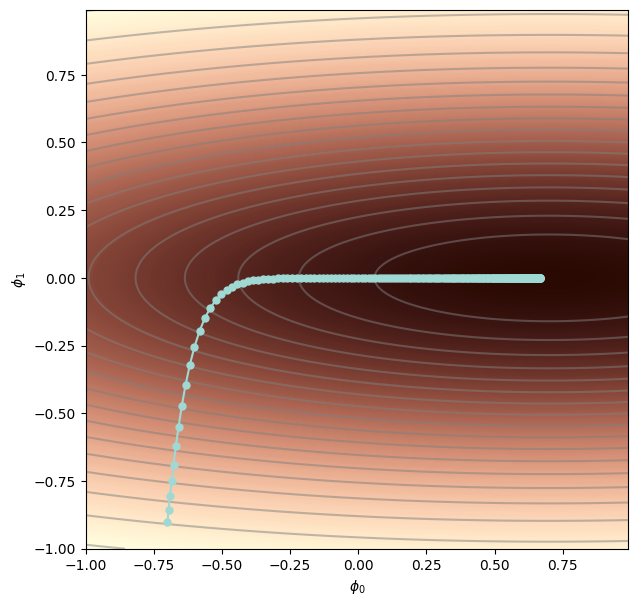

In [89]:
# Run gradient descent
grad_path1 = GradientDescent(start_posn, n_steps=200, alpha = 0.08)
DrawFunction(phi0mesh, phi1mesh, loss_function, my_colormap, grad_path1)

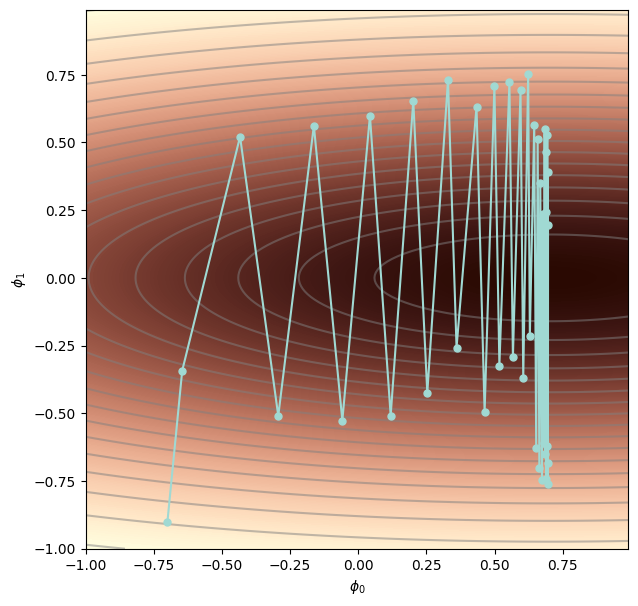

In [90]:
# Run gradient descent
grad_path2 = GradientDescent(start_posn, n_steps=40, alpha= 1.0)
DrawFunction(phi0mesh, phi1mesh, loss_function, my_colormap, grad_path2)

In [91]:
def NormalizedGradients(start_posn, n_steps, alpha, epsilon=1e-20):
    grad_path = np.zeros((2, n_steps+1))
    grad_path[:,0] = start_posn[:,0]
    v = np.zeros_like(grad_path[:,0])
    for c_step in range(n_steps):
        m = LossGradient(grad_path[0,c_step], grad_path[1,c_step])
        v = v + m**2
        grad_path[:,c_step+1] = grad_path[:,c_step] - (alpha / (np.sqrt(v) + epsilon)) * m
    return grad_path

In [92]:
def Adam(start_posn, n_steps, alpha, beta=0.9, gamma=0.99, epsilon=1e-20):
    grad_path = np.zeros((2, n_steps+1))
    grad_path[:,0] = start_posn[:,0]
    m = np.zeros_like(grad_path[:,0])
    v = np.zeros_like(grad_path[:,0])
    for c_step in range(n_steps):
        grad = LossGradient(grad_path[0,c_step], grad_path[1,c_step])
        m = beta * m + (1 - beta) * grad  # Update m
        v = gamma * v + (1 - gamma) * (grad**2)  # Update v
        # Bias correction
        m_tilde = m / (1 - np.power(beta, c_step + 1))
        v_tilde = v / (1 - np.power(gamma, c_step + 1))
        grad_path[:,c_step+1] = grad_path[:,c_step] - (alpha * m_tilde) / (np.sqrt(v_tilde) + epsilon)
    return grad_path

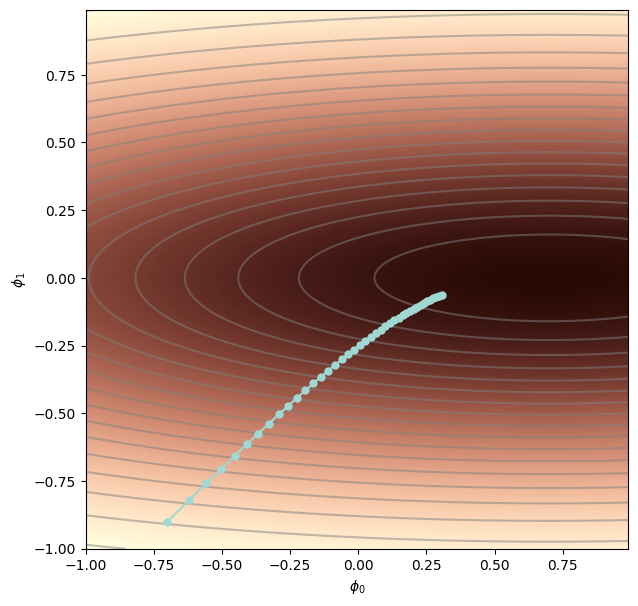

In [93]:
start_posn = np.zeros((2,1));
start_posn[0,0] = -0.7; start_posn[1,0] = -0.9
# Run gradient descent
grad_path1 = NormalizedGradients(start_posn, n_steps=40, alpha = 0.08)
DrawFunction(phi0mesh, phi1mesh, loss_function, my_colormap, grad_path1)

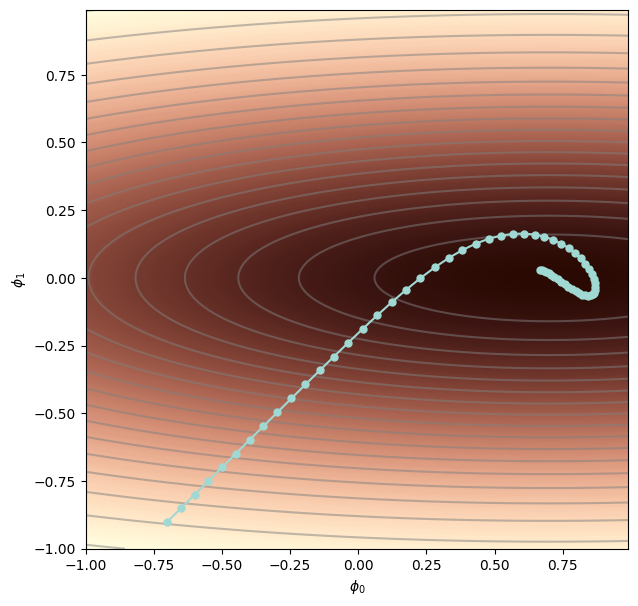

In [94]:
start_posn = np.zeros((2,1));
start_posn[0,0] = -0.7; start_posn[1,0] = -0.9
# Run gradient descent
grad_path1 = Adam(start_posn, n_steps=60, alpha = 0.05)
DrawFunction(phi0mesh, phi1mesh, loss_function, my_colormap, grad_path1)